In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
columns = [
    "lat",
    "lon",
    "id",
    "title",
    "start_ts",
    "report_type",
    "severity",
    "lat_long",
    "severity_score",
    "city",
    "anomalous"
]

In [6]:
df = pd.read_csv("../data/outputs_2016/1wk_window/filter_flagged_reports_1wk.csv")
# df = df.drop(0, axis=1)
# df.columns = columns
df = df.sort_values("start_ts")
print df.head()

                  time       city  row      lat      lon  \
0  2016-01-01 00:45:18    Detroit  269  42.3341 -83.0491   
1  2016-01-01 00:45:48  Baltimore  294  39.1241 -76.7875   
2  2016-01-01 00:45:53  Baltimore  333  40.9947 -77.6045   
3  2016-01-01 00:46:00  St. Louis  339  38.5121 -89.9842   
4  2016-01-01 00:46:01  The Bronx  340  42.6681 -73.8107   

                       id                                              title  \
0  gtwn7iCw5RG8OLyYgvKIJw  Bomb Scares Abound: 12 Suspicious Packages Of ...   
1  IFj8_yCw5RGuMAqagvKIJw  Police Identify Pair Found Dead In Annapolis J...   
2  7uP0AiGw5RGv37uZgvKIJw  Cosby's sexual assault charge leaves blacks fe...   
3  WrwaByGw5RGv37uZgvKIJw  Belleville Police: Chocolate chip cookies and ...   
4  pNXFByGw5RGv37uZgvKIJw        Suspect caught from robbery at Loudon Mobil   

              start_ts       report_type severity  \
0  2016-01-01 00:45:18  Physical Threats  unrated   
1  2016-01-01 00:45:48             Other  unrated   

In [9]:
berlin_df = df[df["city"] == "Berlin"]
berlin_df = berlin_df.set_index("start_ts")
print berlin_df.info()
print berlin_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, 2016-03-11 00:00:00 to 2016-12-31 13:05:51
Data columns (total 13 columns):
time                  739 non-null object
city                  739 non-null object
row                   739 non-null int64
lat                   739 non-null float64
lon                   739 non-null float64
id                    739 non-null object
title                 739 non-null object
report_type           739 non-null object
severity              739 non-null object
lat_long              739 non-null object
severity_quadratic    739 non-null float64
city.1                739 non-null object
anomalous             739 non-null float64
dtypes: float64(4), int64(1), object(8)
memory usage: 80.8+ KB
None
                                    time    city     row        lat  \
start_ts                                                              
2016-03-11 00:00:00  2016-03-11 00:00:00  Berlin  253766  52.515475   
2016-03-11 00:00:00  2016-03-11 00:0

In [10]:
def plot_cutoffs_to_critical_reports(ax, city, df, cutoffs=xrange(1, 101)):
    city_df = df[df["city"] == city]
    city_df = city_df.set_index("start_ts")
    next_day = pd.Timedelta(days=1)
    num_critical = []
    for cutoff in cutoffs:
        lst = []
        for row in city_df.iterrows():
            report_time = pd.to_datetime(row[0])
            stop_time = min(report_time+next_day, pd.to_datetime(max(berlin_df.index)))
            future_reports = city_df[str(report_time):str(stop_time)]
            if len(future_reports) >= cutoff:
                lst.append(1)

        num_critical.append(sum(lst))

    ax.plot(cutoffs, num_critical)
    ax.set_xlabel("Cutoff")
    ax.set_ylabel("Num Critical")
    ax.set_title(city_df.iloc[0,-2])
    

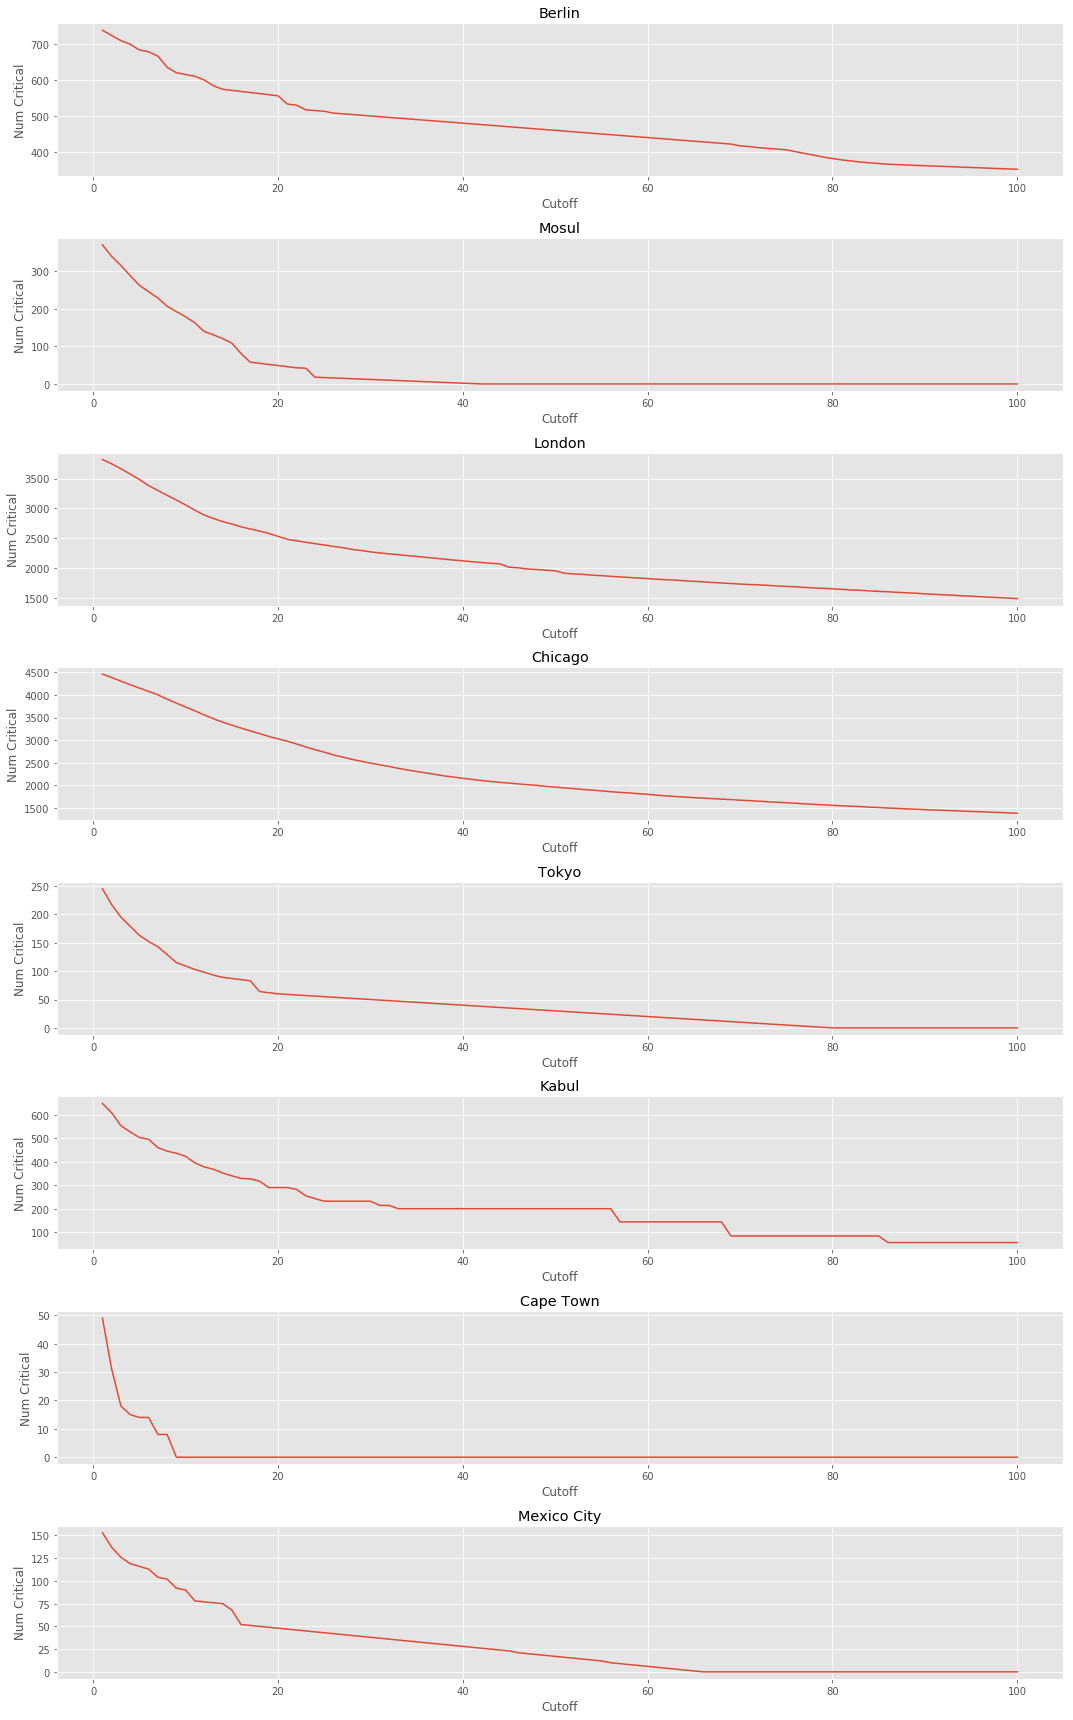

In [11]:
cities = ["Berlin", "Mosul", "London", "Chicago", "Tokyo", "Kabul", "Cape Town", "Mexico City"]
fig, axes = plt.subplots(len(cities), figsize=(15,24))

for i, ax in enumerate(axes.flatten()):
    plot_cutoffs_to_critical_reports(ax, cities[i], df, cutoffs=xrange(1, 101))

plt.tight_layout()

## Given these filter setttings:

    3 minute resample rate
    1 week mean and standard deviation window
    Quadratic severity scoring
    Mean + 1 STD as the anomaly threshold

## 30 anomalous reports over the next 24 hours seems to be a reasonable cutoff for determining whether a report is critical or simply anomalous.

# This cutoff must be tuned based off the specific settings of the filter layer. For example, increasing the threshold to mean + 2 * STD would require reducing the cutoff to ~10 anomalous reports over the next 24 hours. Precise tuning of the complete model will require cross-validation and grid search of BOTH layers simultaneously